# Utilities 

> This module adds some nice utilities functions for circadian data science

In [ ]:
#| default_exp utils

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *

In [ ]:
#| export
import copy
import json
import pytz
import gzip
import torch 
import datetime
from math import *
import scipy as sp
import numpy as np
import pylab as plt
import pandas as pd
from numba import jit
from typing import List
from scipy import interpolate
from scipy.integrate import solve_ivp

In [ ]:
#| export
#| hide
def phase_difference(phase_1: float, # phase between [-pi, pi]
                     phase_2: float # phase between [-pi, pi]
                     ):
    "Phase difference (phase_2 - phase_1). Negative values represent clockwise rotations"
    diff = phase_2 - phase_1
    normalized_diff = (diff + np.pi) % (2 * np.pi) - np.pi
    return normalized_diff

In [ ]:
#| hide
# test phase_difference
test_eq(phase_difference(0.1 * np.pi, -0.1 * np.pi), -0.2 * np.pi)
test_eq(phase_difference(-0.1 * np.pi, 0.1 * np.pi), 0.2 * np.pi)
test_eq(phase_difference(0.9 * np.pi, -0.9 * np.pi), 0.2 * np.pi)
test_eq(phase_difference(-0.9 * np.pi, 0.9 * np.pi), -0.2 * np.pi)
test_eq(phase_difference(0, 0), 0)
test_eq(phase_difference(0, np.pi/2), np.pi/2)
test_eq(phase_difference(np.pi/2, 0), -np.pi/2)

In [ ]:
#| export
#| hide
def amplitude_percent_change(amplitude_1: float, # amplitude between (0, inf)
                             amplitude_2: float # amplitude between (0, inf)
                             ):
    "Percent change between two amplitudes"
    return (amplitude_2 - amplitude_1) / amplitude_1 * 100

In [ ]:
#| hide
# test amplitude_percent_change
test_eq(amplitude_percent_change(1, 2), 100)
test_eq(amplitude_percent_change(2, 1), -50)
test_eq(amplitude_percent_change(1, 1), 0)

In [ ]:
#| export
#| hide
def sleep_midpoint_and_duration(
    time: np.ndarray, # array of time values
    sleep_state: np.ndarray, # array of sleep state values
) -> List[np.ndarray]:
    "Calculate sleep duration and mid-sleep time"
    if not isinstance(time, np.ndarray):
        time = np.array(time)
        raise ValueError("time must be a numpy array")
    if not isinstance(sleep_state, np.ndarray):
        sleep_state = np.array(sleep_state)
        raise ValueError("sleep_state must be a numpy array")
    if len(time) != len(sleep_state):
        raise ValueError("time and sleep_state must have the same length")

    sleep_start_idxs = np.where(np.diff(sleep_state) == 1)[0]
    sleep_end_idxs = np.where(np.diff(sleep_state) == -1)[0] 
    # trim any incomplete sleep windows
    if sleep_start_idxs[0] > sleep_end_idxs[0]:
        sleep_end_idxs = sleep_end_idxs[1:]
    if sleep_start_idxs[-1] > sleep_end_idxs[-1]:
        sleep_start_idxs = sleep_start_idxs[:-1]

    sleep_duration = np.mean(time[sleep_end_idxs] - time[sleep_start_idxs])
    sleep_midpoints = (time[sleep_start_idxs] + time[sleep_end_idxs]) / 2.0
    mid_sleep_time = np.mean(np.mod(sleep_midpoints, 24.0))

    return mid_sleep_time, sleep_duration

mid_sleep: 3.9468901117225275, duration: 7.988160747040185
[  3.92696348  27.95847924  51.93971986  75.97123562  99.95247624
 123.93371686 147.96523262 171.94647324 195.92771386]
[8.04402201 8.04402201 7.94347174 7.94347174 8.04402201 7.94347174
 7.94347174 8.04402201 7.94347174]
(array([   9,  248,  487,  726,  964, 1203, 1442, 1680, 1919], dtype=int64),)


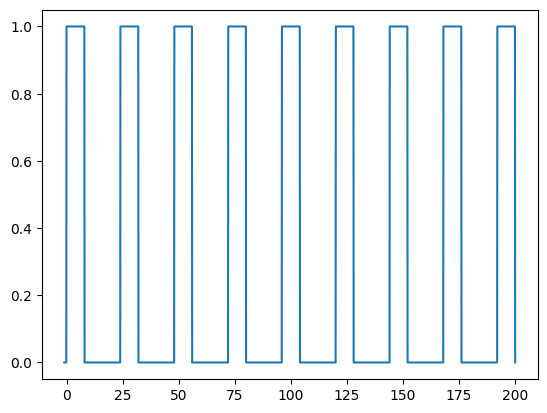

In [ ]:
#| hide
# test sleep_midpoint_and_duration
time = np.linspace(0, 24, 10)
sleep_full_window = np.array([
    0, 1, 1, 1, 1, 1, 1, 0, 0, 0
])
mid_sleep, duration = sleep_midpoint_and_duration(time, sleep_full_window)
test_eq(mid_sleep, 8.0)
test_eq(duration, 16.0)
sleep_half_window = np.array([
    1, 1, 0, 0, 1, 1, 1, 0, 0, 0
])
mid_sleep, duration = sleep_midpoint_and_duration(time, sleep_half_window)
test_eq(mid_sleep, 12.0)
test_eq(duration, 8.0)
# TODO: Perform more testing for larger arrays

In [ ]:
#| export
#| hide
def utc_to_hrs(d: pd.Timestamp # UTC timestamp to convert
               ) -> float: # hours since midnight
    "Convert UTC timestamp to hours since midnight"
    return d.hour + d.minute / 60.0 + d.second / 3600.0

In [ ]:
#| hide
# test utc_to_hrs
test_eq(utc_to_hrs(pd.Timestamp('2020-01-01 00:00:00')), 0)
test_eq(utc_to_hrs(pd.Timestamp('2020-01-01 01:00:00')), 1)
test_eq(utc_to_hrs(pd.Timestamp('2020-01-01 01:30:00')), 1.5)

In [ ]:
#| export 
#| hide
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, datetime.datetime):
            return obj.isoformat()
        return super(NpEncoder, self).default(obj)

In [ ]:
#| export
#| hide
pd.options.mode.chained_assignment = None  # default='warn'

def simple_norm_stepshr_sleep_classifier(t):
        t[0,:] = torch.tanh((t[0,:] - 10.0)/ 100.0)
        t[1, torch.nonzero(t[1,:])] = torch.tanh((t[1,torch.nonzero(t[1,:])] - 60.0) / 30.0)
        return t 

def phase_ic_guess(time_of_day: float) -> float:
    time_of_day = np.fmod(time_of_day, 24.0)

    # Wake at 8 am after 8 hours of sleep
    # State at 00:00
    psi = 1.65238233

    # Convert to radians, add to phase
    psi += time_of_day * np.pi / 12
    return psi

def abs_hour_diff(x, y):
    """
    function abs_hour_diff(x,y)

    Find the difference in hours between
    two clock times (wrapped)
    """
    a1 = min(x, y)
    a2 = max(x, y)
    s1 = a2-a1
    s2 = 24.0+a1-a2
    return(min(s1, s2))


def cut_phases_12(p):
    """
    Function to make the branch cut for the DLMO times be at 12 instead of 24.
    This is better because lots of DLMOs are near midnight, but many fewer are near
    noon.

        cut_phases_12(timept)
    """

    while (p < 0.0):
        p += 24.0

    p = np.fmod(p, 24.0)

    if p > 12:
        return p-24.0
    else:
        return p


def convert_binary(x, breakpoint: float = 0.50):
    x[x <= breakpoint] = 0.0
    x[x > breakpoint] = 1.1
    return x


def cal_days_diff(a, b):
    """Get the calander days between two time dates"""
    A = a.replace(hour=0, minute=0, second=0, microsecond=0)
    B = b.replace(hour=0, minute=0, second=0, microsecond=0)
    return (A - B).days


@jit(nopython=True)
def interpolateLinear(t, xvals, yvals):
    """Implement a faster method to get linear interprolations of the light functions"""

    if (t >= xvals[-1]):
        return (0.0)
    if (t <= xvals[0]):
        t += 24.0

    i = np.searchsorted(xvals, t) - 1
    ans = (yvals[i + 1] - yvals[i]) / \
          ((xvals[i + 1] - xvals[i]) * (t - xvals[i])) + yvals[i]
    return (ans)


@jit(nopython=True)
def interpolateLinearExt(t, xvals, yvals):
    """Implement a faster method to get linear interprolations of the light functions, exclude non-full days"""
    i = np.searchsorted(xvals, t) - 1
    ans = (yvals[i + 1] - yvals[i]) / \
          ((xvals[i + 1] - xvals[i]) * (t - xvals[i])) + yvals[i]
    return (ans)


def parse_dt(date, time):
    strDate = date + ' ' + time
    return pd.to_datetime(strDate, format='%m/%d/%Y %I:%M %p')


## Circular Stats

In [ ]:
#| export 
#| hide
def circular_mean(series):
    Z=complex(0,0)
    series=np.array(series)
    for i in range(len(series)):
        Z+=np.exp(series[i]*complex(0,1))

    Z=Z/float(len(series))

    ans=np.angle(Z)
    if (ans<0.0):
        ans+=2*sp.pi
    return(ans)

def phase_coherence(series):
    Z=complex(0,0)
    series=np.array(series)
    for i in range(len(series)):
        Z+=np.exp(series[i]*complex(0,1))

    Z=Z/float(len(series))

    ans=np.absolute(Z)
    return(ans)

def phase_coherence_clock(series):
    angles=np.pi/12.0*series
    return(phase_coherence(angles))

def angle_difference(c1, c2) -> float:
    """Find the angle between two angles given in radians
    angle_difference(c1, c2)
    c1-c2
    """

    return(np.angle(np.exp(complex(0,1)*(c1-c2))))


def subtract_clock_times(c1, c2):
    """Find the hour differences between two clock times new"""
    a1=sp.pi/12.0*c1
    a2=sp.pi/12.0*c2
    adiff=angle_difference(a1, a2)
    return(12.0/sp.pi*adiff)


def circular_av_clock(series):
    """Find the average time given a list of clock times"""
    angles=sp.pi/12.0*series
    ans_angle=circular_mean(angles)
    #back to clock time
    return(ans_angle*12.0/sp.pi)
    

def circular_scatter(ax, angles, clock_times=False, radius=1.0, color='blue'):
    """Adds a polar scatter plot of clock times to an axes with polar axis i.e.
        ax = plt.subplot(111, polar=True)
        Will also plot the circular mean angle and the phase coherence
    """
    
    angles=np.array(angles)
    radii=radius*np.ones(len(angles))


    if clock_times:
        angles=angles*sp.pi/12.0

    ax.scatter(angles, radii, color=color)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_thetagrids(list(range(0,360,45)), list(range(0,24,3)))
    ax.set_rmax(1.2)
    ax.set_rticks([0.0,0.2,0.6,0.8,1.0])
    ax.annotate("", xytext=(0.0,0.0), xy=(circular_mean(angles),phase_coherence(angles)),arrowprops=dict(facecolor=color))

## Data related utils

In [ ]:
#| export
#| hide
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


def times_to_angle(time_vector: np.ndarray):
    """
        Take an array of times and return R, psi 
        giving the mean angle (psi) and amplitude (R)
    """
    rad_vector = np.fmod(time_vector, 24.0) * np.pi/12.0
    Z = np.sum(np.exp(rad_vector*1j))/len(rad_vector)
    return(np.abs(Z), np.angle(Z))


def timezone_mapper(dt_object: datetime, timezone: str = 'America/Detroit'):
    """
        Take in local time as datetime object and give back UTC with 
        day lights savings accounted for as a timestamp
    """

    local_timezone = pytz.timezone(timezone)
    return local_timezone.localize(dt_object).timestamp()


def split_missing_data(date_time, ts, y, hr=None, break_threshold=96.0):

    # Find idx at start and end of long periods of zeros

    idx_start = None
    idx_end = None
    in_region = False
    crop_regions = []

    for (k, t) in enumerate(ts):
        if y[k] <= 0.0 and not in_region:
            idx_start = k
            in_region = True
        if y[k] > 0.0 and in_region:
            idx_end = k-1
            in_region = False
            if ts[idx_end]-ts[idx_start] >= break_threshold:
                crop_regions += [idx_start, idx_end]
    ts_split = np.split(ts, crop_regions)
    y_split = np.split(y, crop_regions)

    if hr is not None:
        hr_split = np.split(hr, crop_regions)

    print(f"Splitting data into {len(y_split)} regions")

    if hr is not None:
        return np.split(date_time, crop_regions), ts_split, y_split, hr_split
    else:
        return np.split(date_time, crop_regions), ts_split, y_split


def split_drop_data(date_time, ts, steps, hr, wake, break_threshold=96.0, min_length: float = 30.0):
    """
        Used to split long JSON into contin data steaks of at 
        least X=30 days.

        Uses that missing data will be zeros for steps and hr  and 
        0.5 for the wake data. 

        min_length is in days
    """

    idx_start = None
    idx_end = None
    in_region = False
    crop_regions = []

    for (k, t) in enumerate(ts):
        if (steps[k] <= 0.0 or hr[k] <= 0 or wake[k] == 0.50) and not in_region:
            idx_start = k
            in_region = True
        if steps[k] > 0.0 and hr[k] > 0 and wake[k] != 0.50 and in_region:
            idx_end = k-1
            in_region = False
            if ts[idx_end]-ts[idx_start] >= break_threshold:
                crop_regions += [idx_start, idx_end]

    ts_split = np.split(ts, crop_regions)
    steps_split = np.split(steps, crop_regions)
    hr_split = np.split(hr, crop_regions)
    wake_split = np.split(wake, crop_regions)
    date_time = np.split(date_time, crop_regions)

    # Find idxs for regions which are longer than min_length

    idx_long = [k for (k, val) in enumerate(ts_split)
                if (val[-1]-val[0])/24.0 >= min_length]

    if len(idx_long) > 0:
        return ([date_time[i] for i in idx_long], [ts_split[idx] for idx in idx_long], [steps_split[i] for i in idx_long],
                [hr_split[i] for i in idx_long], [wake_split[i] for i in idx_long])
    else:
        return None

This function can be used to redact the dates from a json file, this is to protect the user privacy. The start of the timestamps will
be set back to the unix epoch time. 

In [ ]:
#| export 
#| hide
def redact_dates(infile: str, # the input file in json format
                 outfile: str, # the output file in json format with dates redacted, for user privacy
                 gzip_opt: bool = False # if the input file is gzipped, if the extension is .gz, this is set to True
                 ) -> None:
    gzip_opt = gzip_opt if gzip_opt else infile.endswith(".gz")
    fileobj = gzip.open(infile, 'r') if gzip_opt else open(infile, 'r')
    data = json.load(fileobj)
    
    first_time = data['steps'][0]['start']
    for i in range(len(data['steps'])):
        data['steps'][i]['start'] -= first_time
        data['steps'][i]['end'] -= first_time 
    for i in range(len(data['heartrate'])):
        data['heartrate'][i]['timestamp'] -= first_time
    for i in range(len(data['wake'])):
        data['wake'][i]['start'] -= first_time
        data['wake'][i]['end'] -= first_time
        
    json.dump(data, open(outfile, 'w'))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()